In [52]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [53]:
# Reading through the IMDB data to see what peoples feelings were towards movies
data = pd.read_csv('imdb_labelled.txt', delimiter = '\t', header = None)
data.columns = ['message', 'rating']
train, test = train_test_split(data, test_size = .2, random_state = 1)

In [54]:
data.head() # I have to recode the above lines after every holdout since it doesn't seem to
#keep the 'data' variable clean after coding one. We should talk about why.

,message,rating
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [55]:
# building separate dataframes from the positive and negative reviews
pos_data = data[data['rating'] == 1]['message'].reset_index(drop = True)
neg_data = data[data['rating'] == 0]['message'].reset_index(drop = True)

In [56]:
#building dictionaries to find the most common words for each review type
pos_dict = {}
neg_dict = {}
for i in pos_data:
    sen = str(i).lower().split(' ')
    for word in sen:
        if word not in pos_dict:
            pos_dict[word] = 1
        else:
            pos_dict[word] += 1            

for i in neg_data:
    sen = str(i).lower().split(' ')
    for word in sen:
        if word not in neg_dict:
            neg_dict[word] = 1
        else:
            neg_dict[word] += 1
            

In [57]:
sorted_pos_dict = sorted(pos_dict.items(), key=operator.itemgetter(1), reverse = True)
sorted_neg_dict = sorted(neg_dict.items(), key=operator.itemgetter(1), reverse = True)

In [58]:
df_pos = pd.DataFrame(sorted_pos_dict)
df_pos.columns = ['word', 'count']
df_neg = pd.DataFrame(sorted_neg_dict)
df_neg.columns = ['word', 'count']

In [59]:
#merging positive and negative lists to get counts for each
posneg_df = pd.merge(df_pos, df_neg, on='word', how='outer')
posneg_df.columns = ['word', 'positive', 'negative']

#building a dataframe that calculates absolute difference in word appearance counts
posneg_df['straight difference'] = abs(posneg_df.positive - posneg_df.negative)

#dataframe that calculates ratio difference
posneg_df['ratio difference'] = abs((posneg_df.negative / (posneg_df.positive + posneg_df.negative)))

In [60]:
posneg_df.head()

,word,positive,negative,straight difference,ratio difference
0,,842.0,910.0,68.0,0.519406
1,the,388.0,407.0,19.0,0.511950
2,and,249.0,170.0,79.0,0.405728
3,a,227.0,200.0,27.0,0.468384
4,of,184.0,189.0,5.0,0.506702


In [61]:
# I used a lot of the words high on this list figuring the larger the difference in usage
# the more effect it would have on the predictive value of the model
posneg_df.sort_values(by = 'negative', ascending = False)[101:140]

,word,positive,negative,straight difference,ratio difference
67,her,12.0,9.0,3.0,0.428571
52,when,16.0,9.0,7.0,0.360000
161,never,6.0,9.0,3.0,0.600000
69,movies,12.0,9.0,3.0,0.428571
176,get,5.0,9.0,4.0,0.642857
60,its,14.0,9.0,5.0,0.391304
116,films,8.0,9.0,1.0,0.529412
2247,am,1.0,8.0,7.0,0.888889
2433,\t0\nbut,NaN,8.0,NaN,NaN
2434,\t1\nit,NaN,8.0,NaN,NaN


In [62]:
data.head()

,message,rating
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [63]:
# Building my keyword list
train1 = train
test1 = test

keywords_mine = ['and',
            'even',
            'good',
            'plot',
            'enjoy',
            'best', #not very strong
            'love',
            'cool', #also pretty weak
            'awesome',
            'film',
            'for',
            'is',
            'was',
            'i',
            'not',
            'a',
            'to',
            'just',
            'know',
            'wonderful',
            'only',
            'great',
            'bad.',
            'waste',
            'like',
            'really',
            'excellent',
           ]
for key in keywords_mine:
    train1[str(key)] = train1.message.str.contains(
        str(key), case = False #getting rid of the spaces in order to find words at beginning or end of sentences
    )
    test1[str(key)] = test1.message.str.contains(
        str(key), case = False #getting rid of the spaces in order to find words at beginning or end of sentences
    )
    
# Pretty light correlation outside of 'was' and 'waste' from from the sentence 'this 
# movie was a waste of time'

train_x = train1[keywords_mine]
train_y = train1['rating']

test_x = test1[keywords_mine]
test_y = test1['rating']

#creating an instantiating variable for the BernoulliNB
bnb1 = BernoulliNB()

bnb1.fit(train_x, train_y)

y_pred_train = bnb1.predict(train_x)
y_pred_test = bnb1.predict(test_x)

print("Training accuracy out of a total of {} reviews : {}".format(
    train_x.shape[0],
    (train_y == y_pred_train).sum()/train_x.shape[0])
)

print("Test accuracy out of a total of {} reviews : {}".format(
    test_x.shape[0],
    (test_y == y_pred_test).sum()/test_x.shape[0])
)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training accuracy out of a total of 598 reviews : 0.717391304347826
Test accuracy out of a total of 150 reviews : 0.7133333333333334


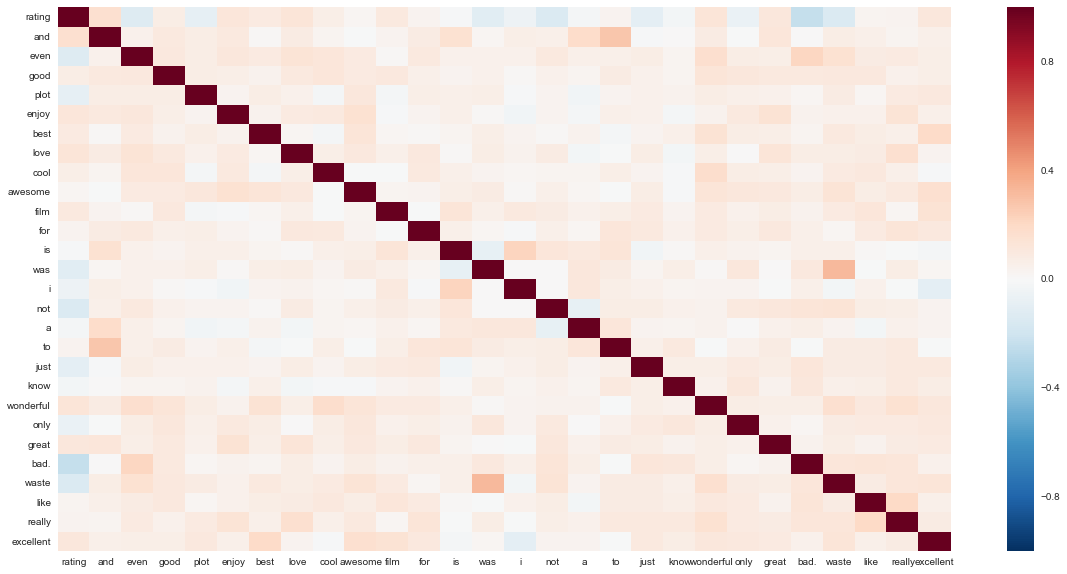

In [64]:
plt.figure(figsize = (20,10))
sns.heatmap(train1.corr())

In [65]:
train, test = train_test_split(data, test_size = .2, random_state = 1)

In [66]:
# Building a keyword list based on the straight difference count
train2 = train
test2 = test

keywords_straight_diff = ['and',
    'is',
    'was',
    'bad',
    'a',
    'to',
    'just',
    'even',
    'i',
    'the',
    'no',
    'that',
    'how',
    'in',
    'for',
    "didn't",
    'good',
    'plot',
    'would',
    'wonderful',
    'only',
    'there',
    '\t\ni',
    'it',
    'great'
]
                          
for key in keywords_straight_diff:
    train2[str(key)] = train2.message.str.contains(
        str(key), case = False #getting rid of the spaces in order to find words at beginning or end of sentences
    )
    test2[str(key)] = test2.message.str.contains(
        str(key), case = False #getting rid of the spaces in order to find words at beginning or end of sentences
    )

train2_x = train2[keywords_straight_diff]
train2_y = train2['rating']

test2_x = test2[keywords_straight_diff]
test2_y = test2['rating']

#creating an instantiating variable for the BernoulliNB
bnb2 = BernoulliNB()

bnb2.fit(train2_x, train2_y)

y_pred2_train = bnb2.predict(train2_x)
y_pred2_test = bnb2.predict(test2_x)

print("Training accuracy out of a total of {} reviews : {}".format(
    train2_x.shape[0],
    (train2_y == y_pred2_train).sum()/train2_x.shape[0])
)

print("Test accuracy out of a total of {} reviews : {}".format(
    test2_x.shape[0],
    (test2_y == y_pred2_test).sum()/test2_x.shape[0])
)

#print(confusion_matrix(target2, y_pred2))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training accuracy out of a total of 598 reviews : 0.6939799331103679
Test accuracy out of a total of 150 reviews : 0.6466666666666666


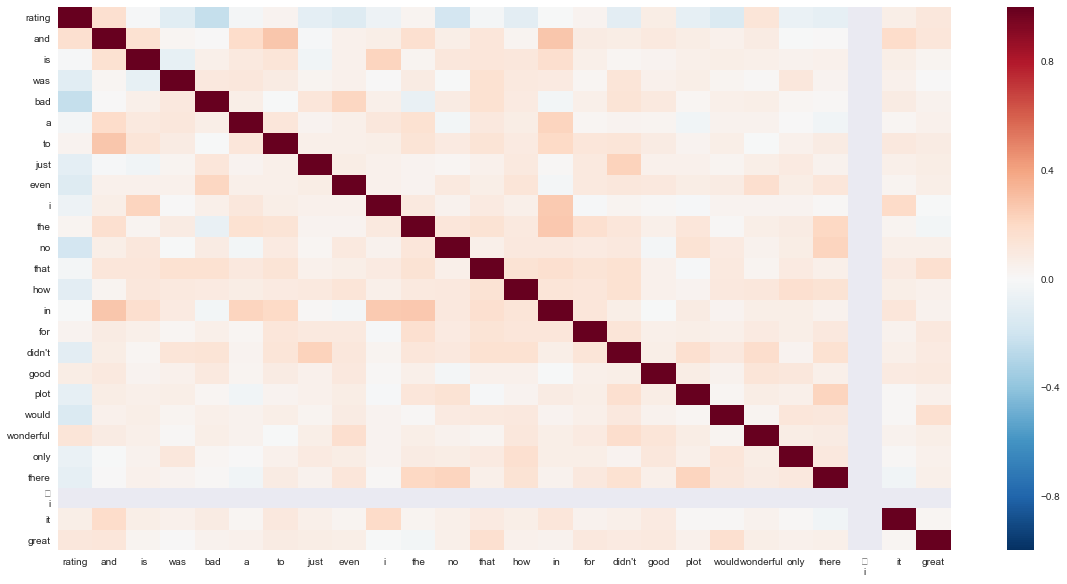

In [67]:
plt.figure(figsize = (20,10))
sns.heatmap(train2.corr())

In [68]:
train, test = train_test_split(data, test_size = .2, random_state = 1)

In [69]:
# Building a keyword list based on the ratio difference count
train3 = train
test3 = test

keywords_ratio_diff = ['waste',
                      'show',
                      'nothing',
                      'am',
                      'line',
                      'bad',
                      '\t\ni',
                      'seen.',
                      "didn't",
                      'plot',
                      'work',
                      'especially',
                      'half',
                      'terrible,',
                      "i'm",
                      'lacks',
                      'films',
                      'would',
                      'even',
                      'beyond',
                      'predictable',
                      'why',
                      'funny.',
                      'well,'
]
                          
for key in keywords_ratio_diff:
    train3[str(key)] = train3.message.str.contains(
        str(key), case = False #getting rid of the spaces in order to find words at beginning or end of sentences
    )
    test3[str(key)] = test3.message.str.contains(
        str(key), case = False #getting rid of the spaces in order to find words at beginning or end of sentences
    )

train3_x = train3[keywords_ratio_diff]
train3_y = train3['rating']

test3_x = test3[keywords_ratio_diff]
test3_y = test3['rating']

#creating an instantiating variable for the BernoulliNB
bnb3 = BernoulliNB()

bnb3.fit(train3_x, train3_y)

y_pred3_train = bnb3.predict(train3_x)
y_pred3_test = bnb3.predict(test3_x)

print("Training accuracy out of a total of {} reviews : {}".format(
    train3_x.shape[0],
    (train3_y == y_pred3_train).sum()/train3_x.shape[0])
)

print("Test accuracy out of a total of {} reviews : {}".format(
    test3_x.shape[0],
    (test3_y == y_pred3_test).sum()/test3_x.shape[0])
)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training accuracy out of a total of 598 reviews : 0.6705685618729097
Test accuracy out of a total of 150 reviews : 0.6266666666666667


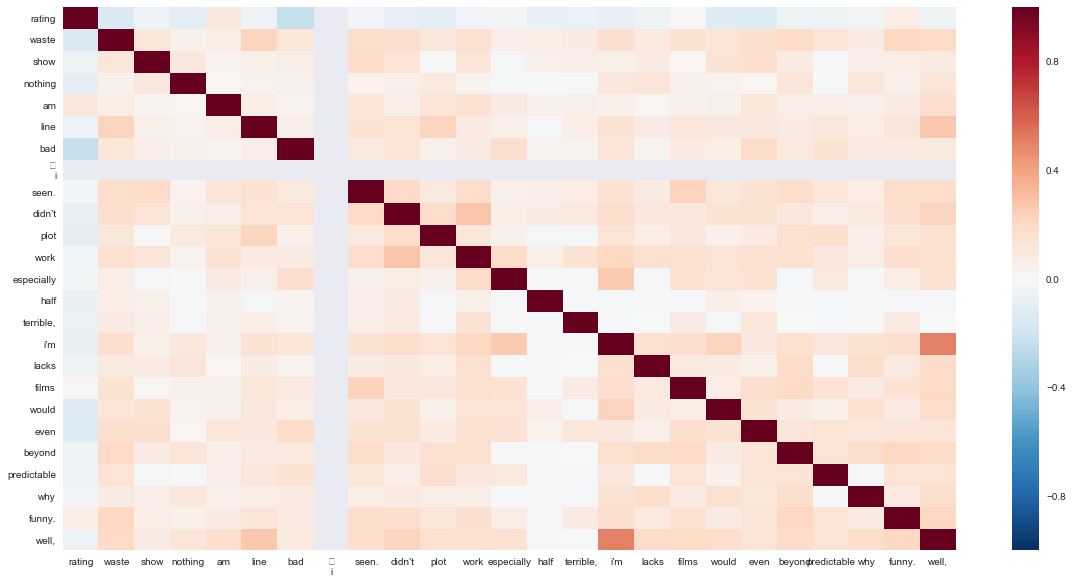

In [70]:
plt.figure(figsize = (20,10))
sns.heatmap(data3.corr())

In [71]:
train, test = train_test_split(data, test_size = .2, random_state = 1)

In [72]:
# Building a keyword list based on the most common positive words that are not base words
# base words being your (a, the, if, or, and type words)
train4 = train
test4 = test

keywords_pos_words = [
    'movie',
    'film',
    'good',
    'great',
    'like',
    'more',
    'wonderful',
    'best',
    'love',
    'character',
    'worth',
    'excellent',
    'recommend',
    'interesting',
    'enjoyed',
    'well.',
    '10',
    'it!',
    'special',
    'perfect'
]
                          
for key in keywords_pos_words:
    train4[str(key)] = train4.message.str.contains(
        str(key), case = False #getting rid of the spaces in order to find words at beginning or end of sentences
    )
    test4[str(key)] = test4.message.str.contains(
        str(key), case = False #getting rid of the spaces in order to find words at beginning or end of sentences
    )

train4_x = train4[keywords_pos_words]
train4_y = train4['rating']

test4_x = test[keywords_pos_words]
test4_y = test['rating']

#creating an instantiating variable for the BernoulliNB
bnb4 = BernoulliNB()

bnb4.fit(train4_x, train4_y)

y_pred4_train = bnb4.predict(train4_x)
y_pred4_test = bnb4.predict(test4_x)

print("Training accuracy out of a total of {} reviews : {}".format(
    train4_x.shape[0],
    (train4_y == y_pred4_train).sum()/train4_x.shape[0])
)

print("Test accuracy out of a total of {} reviews : {}".format(
    test4_x.shape[0],
    (test4_y == y_pred4_test).sum()/test4_x.shape[0])
)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training accuracy out of a total of 598 reviews : 0.6521739130434783
Test accuracy out of a total of 150 reviews : 0.62


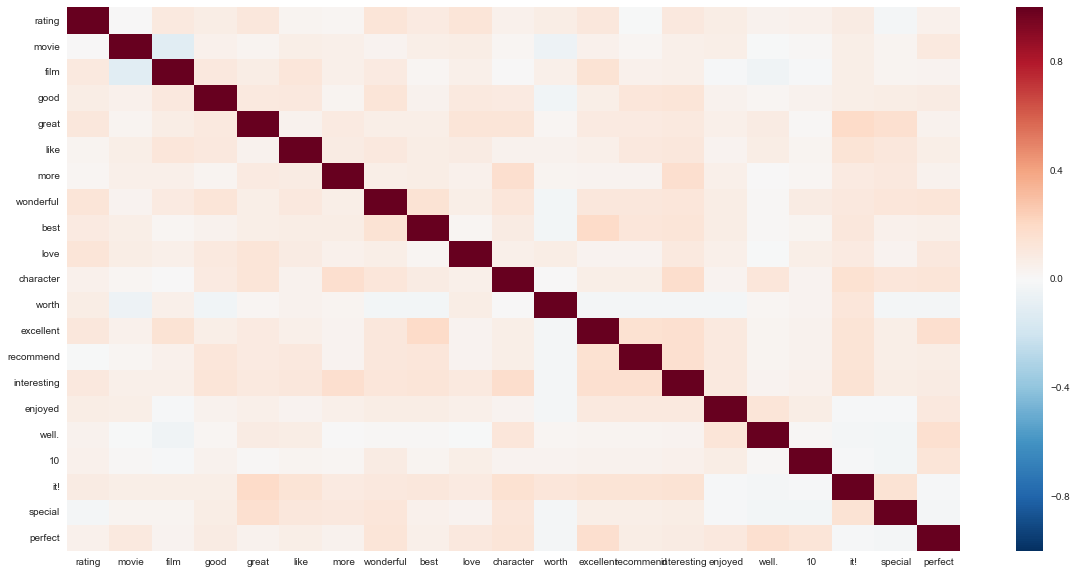

In [73]:
plt.figure(figsize = (20,10))
sns.heatmap(train4.corr())

In [74]:
train, test = train_test_split(data, test_size = .2, random_state = 1)

In [75]:
# Building a keyword list based on the most common negative words that are not base words
# base words being your (a, the, if, or, and type words)
train5 = train
test5 = test

keywords_neg_words = [
    'movie',
    'just',
    'bad',
    'even',
    'no',
    'only',
    'plot',
    "didn't",
    'how',
    'your',
    'waste',
    'little',
    'nothing',
    'worst',
    'stupid',
    'worse',
    'awful'
]
                          
for key in keywords_neg_words:
    train5[str(key)] = train5.message.str.contains(
        str(key), case = False #getting rid of the spaces in order to find words at beginning or end of sentences
    )
    test5[str(key)] = test5.message.str.contains(
        str(key), case = False #getting rid of the spaces in order to find words at beginning or end of sentences
    )

train5_x = train5[keywords_neg_words]
train5_y = train5['rating']

test5_x = test5[keywords_neg_words]
test5_y = test5['rating']

#creating an instantiating variable for the BernoulliNB
bnb5 = BernoulliNB()

bnb5.fit(train5_x, train5_y)

y_pred5_train = bnb5.predict(train5_x)
y_pred5_test = bnb5.predict(test5_x)

print("Training accuracy out of a total of {} reviews : {}".format(
    train5_x.shape[0],
    (train5_y == y_pred5_train).sum()/train5_x.shape[0])
)

print("Test accuracy out of a total of {} reviews : {}".format(
    test5_x.shape[0],
    (test5_y == y_pred5_test).sum()/test5_x.shape[0])
)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training accuracy out of a total of 598 reviews : 0.6956521739130435
Test accuracy out of a total of 150 reviews : 0.6866666666666666


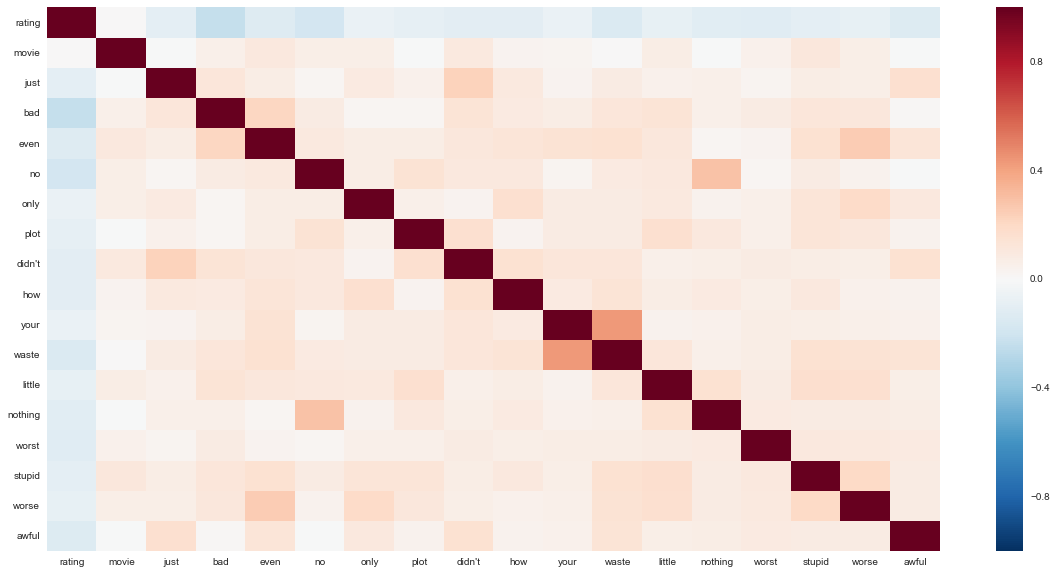

In [76]:
plt.figure(figsize = (20,10))
sns.heatmap(train5.corr())

## Do any of your classifiers seem to overfit?

The only classifier that might have some overfitting was the 'straight difference' classifier. The rest only performed marginally better on the training set vs the test set.

## Which seem to perform the best and why?

Based on accuracy measures, my Keywords had the best predictive value. Surprisingly the ratio and straight difference models were not very different in accuracy levels and the negative words model was the second strongest at prediction although it was still very similar to the other four.

## What features seem to be most impactful to performance

Based on the accuracy scores and the eye test it seems that accurately predicting negative reviews is easier than positive ones. This makes some sense when you think of who writes reviews. Normally if you have a good experience it isn't worthy of writing a positive review but people who have any sort of negative experience(think Yelp) are much more likely to share their experiences/vent about it.